## Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import csr_matrix as csr
import scipy.sparse as ss
import pickle
from datetime import datetime as dt
import math
import operator as op
from functools import reduce

## Data Source

In [16]:
data = <PATH>

## Preprocessing

In [ ]:
edge = []

f = open(<PATH>, 'r')
list = f.read().splitlines()

for i in range(len(list)):
    a = list[i]
    b = a.split()
    b = [int(i) for i in b]
    edge.append(b)
#print(edges)
edge = np.asarray(edge)
edge = edge.astype(int)
vertices = edge.max()
edges2x=np.zeros((2*len(edge),2))
for i in range(len(edge)):
    edges2x[2*i,0] = edge[i,0]
    edges2x[2*i,1] = edge[i,1]
    edges2x[2*i+1,0] = edge[i,1]
    edges2x[2*i+1,1] = edge[i,0]
    
edges2x = edges2x.astype(int)
adj = [[] for _ in range(vertices+1)]
for i in tqdm(range(len(edges2x))):
    j = edges2x[i,0]
    adj[j].append(edges2x[i,1])
    #print(i, j)
#print(adj[j])


In [4]:
edge[:,:2] = np.sort(edge[:,:2])
edges = np.unique(edge, axis = 0) #prevent duplication

In [ ]:
np.unique(edges, axis = 0).shape[0]/edges.shape[0] #check for duplication

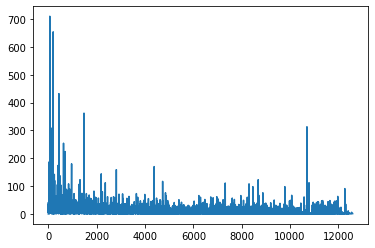

In [6]:
degree = np.zeros(len(adj))
for i in range(len(degree)):
    degree[i] = len(adj[i])
plt.plot(degree)
degree = degree.astype(int)

In [ ]:
rows = edges[:,0]
cols = edges[:,1]
roots = np.sqrt(degree)
weights = np.zeros(len(edges))
for i in tqdm(range(len(edges))):
    weights[i] = 1/(roots[edges[i,0]]*roots[edges[i,1]])

edge_weights = csr((weights, (rows,cols)))
ss.save_npz(data+"edgeweights.npz", edge_weights)

In [ ]:
tri =[]
for i in tqdm(range(1,vertices+1)):
    for j in adj[i]:
        tris = np.intersect1d(adj[i],adj[j])
        if tris.size:
            for x in tris:
                tri.append([i,j,x])

In [ ]:
tri = np.asarray(tri) 

tri[:,:3] = np.sort(tri[:,:3])  #necessary to remove duplicates with unique

print(tri.shape)

trip = np.unique(tri[:,:3], axis = 0) #remove duplicates


trianglewtstmp = np.zeros(trip.shape[0])
tri = np.insert(trip, 3, trianglewtstmp, axis = 1) #append row for weights
tri = tri.astype(np.float64)
#print()

for i in tqdm(range(len(trianglewtstmp))):
    k = trip [i,0]
    j = trip [i,1]
    x = trip [i,2]
    tri[i,3] = 1/((roots[k]*roots[j]*roots[x])**2) #assign weights
        
    
print(tri.shape)

In [ ]:
test = np.zeros ((tri.shape[0],5))
test[:,:4] = tri
test[:,4] = 1 #add label for present; when triangles are removed from the graph due to cleaning or extraction, label is changed to 0
print(test)
tri = test

In [ ]:
edgetri = np.zeros((edges.shape[0], 4)) #similar format for triangle weights on edges
print(edgetri.shape)
edgetri[:,3] = 1
edgetri[:,:2] = edges[:,:2]
for i in tqdm(range(edges.shape[0])):
    x = edgetri[i,0].astype(int)
    y = edgetri[i,1].astype(int)
    common = np.intersect1d(adj[x],adj[y])
    sums = 0
    for a in common:
        sums = sums + 1/(roots[a]**2)
    edgetri[i, 2] = 1/((roots[x]*roots[y])**2)*sums

#print(edgetri)
        

In [ ]:
test2 = np.zeros((edges.shape[0],4))
test2[:,:2]=edges
test2[:,2] = weights
test2[:,3] = 1
edges = test2 #appending column with labels for edges (binary label for present/not)
#print(edges)

In [ ]:
vtxlist = np.zeros((vertices+1,3))
for i in range(vertices+1):
    vtxlist[i,0] = i
    vtxlist[i,1] = degree[i]
    vtxlist[i,2] = 1
vtxlist = vtxlist.astype(int) #additional array for vertices, degrees and labels 

In [ ]:
#verify formats

tri, edges, edgetri, vtxlist

## Save to file (ignore if not first time)

In [ ]:
with open(data+"list.pickle", "wb") as fp:   #Pickling
    pickle.dump(adj, fp)
with open(data+"edges.pickle", "wb") as fp2:   #Pickling
    pickle.dump(edges, fp2)
with open(data+"alltriangles.pickle", "wb") as fp3:   #Pickling
    pickle.dump(tri, fp3)
with open(data+"trianglebyedge.pickle", "wb") as fp4:   #Pickling
    pickle.dump(edgetri, fp4)
np.save(data+"degrees", degree)

In [ ]:
np.save(data+"vtxlist", vtxlist)

## Cleaning

In [9]:
def clean(edgep, edgetrip, adjs, epsilon, degree, trip, vtx):
    
    length = np.sum(vtx[:,2])
    
    times = 5
    
    tris = trip.copy()
    edge = edgep.copy()
    edgetris = edgetrip.copy()
    
    for k in range(times):
        for i in range(len(edge)):
            if edge[i,3] == 1 and edgetris[i,2]<epsilon*edge[i,2]:
                edge[i,3] = 0
                edgetris[i,3] = 0
                x = edge[i,0].astype(int)
                y = edge[i,1].astype(int)
                #print(x,y)
                intersect = np.intersect1d(adjs[x],adjs[y])
                if y in adjs[x]:
                    adjs[x].remove(y)
                if x in adjs[y]:
                    adjs[y].remove(x)
                #print(intersect)
                for z in intersect:
                    wt = (1/(degree[x]*degree[y]*degree[z]))**(0.5)
                    a, b, c = np.sort(np.array([x, y, z]))
                    #print(a,b,c)
                    triangleloc = np.where((tris[:, 0] == a) & (tris[:, 1] == b) & (tris[:, 2] == c))[0]
                    #print(triangleloc)
                    tris[triangleloc, 4] = 0 
                    edge_1 = np.where((edge[:, 0] == a) & (edge[:, 1] == b))[0][0] #remove all incident triangles
                    edge_2 = np.where((edge[:, 0] == a) & (edge[:, 1] == c))[0][0]
                    edge_3 = np.where((edge[:, 0] == b) & (edge[:, 1] == c))[0][0]
                    #if i == 14890:
                    #    print(a, b, c)
                    edgetris[edge_1,2] = edgetris[edge_1,2] - wt #update weights on edges corresponding to removed triangles
                    edgetris[edge_2,2] = edgetris[edge_2,2] - wt
                    edgetris[edge_3,2] = edgetris[edge_3,2] - wt 
                    
    for i in range(len(adjs)):
        vtx[i,1] = len(adjs[i])
        if len(adjs[i]) == 0:
            vtx[i,2] = 0
            
    for i in range(edge.shape[0]):
        if edge[i,3] == 0:
            x = edge[i,0].astype(int)
            y = edge[i,1].astype(int)
            if x in adjs[y]:
                adjs[y].remove(x)
            if y in adjs[x]:
                adjs[x].remove(y)
                
    z = np.where(vtx[:,2]==1)[0]
    if vtx[z,1].max() == 1:
        vtx[z,2] = 0
        
    return edge, edgetris, tris, adjs, vtx

## Extraction

In [10]:
#this is for dblp; modified

def extract(adjp, degree, vtxlistx, trip, eps, eps2, edgex):
    
    adjx = adjp.copy()
    
    indices = np.nonzero(degree)[0]
    order = indices[np.argsort(degree[indices])]
   
    k = order[0]
    i = 0
    
    trix = trip[np.where(trip[:,4]!=0)]
    
    #print(order.shape)
    
    while vtxlistx[k,2] == 0 or vtxlistx[k,1]<2:
        i = i+1
        k = order[i]
        #print(k)
    
    #print(k)
    
    delta = degree[k] 
    print('Delta =', delta)
    
    vtx =  []
    
    vtx.append(k)
    #print(k, adjx[k])
    for i in adjx[k]:
        if degree[i]<delta/eps**2 and vtxlistx[i,2]==1:
            #print('true')
            vtx.append(i)
        #else:
            #print('false')
            
    twohop = [] 
    vtx = np.asarray(vtx)
    vtx = vtx.astype(int)
    #print(vtx)
    for i in vtx:
        #print('i is ', i)
        twohop = np.union1d(twohop,adjx[i])
        #print('twohop is ', twohop)
        #print(adjx[i])
        
    
    #print(twohop)
    
    twohop = np.setdiff1d(twohop,vtx)
    twohop = np.asarray(twohop)
    twohop = twohop.astype(int)
    vtx = np.union1d(vtx,twohop)
    
    
    rem = []
    
    for i in twohop:
        if len(adjx[i])>4*len(np.intersect1d(vtx,adjx[i])): #proxy for true extraction: include only vertices with high intersection with one hop neighborhood, makes computations faster without significant changes to outcome
            rem.append(i)
    
    vtx = np.setdiff1d(vtx,rem)
    
    #vtx = np.union1d(vtx,twohop)
            
    #for i in range(trix.shape[0]):
    #    if trix[i,0] in vtx:
    #        a = np.where(edge[])
            
    for v in vtx: #update removal of extracted vertices from entire graph; corresponding removal from edge and triangle list done in function trim
        vtxlistx[v,2] = 0
        for i in range(vtxlistx.shape[0]):
            if v in adjx[i]:
                adjx[i].remove(v)
        adjx[v] = []
        
    size = len(vtx)
    print(size)
    total = size*(size-1)/2
    dsty = 0
        
    for i in range(edgex.shape[0]):
        if edgex[i,0] in vtx and edgex[i,1] in vtx and edgex[i,3]==1:
            dsty = dsty+1
    
    dsty = dsty/total
    
    return vtx, vtxlistx, adjx, dsty
        

## Helper Functions for Statistics

In [11]:
def trim(edges_x, edgetri_x, tri_x, vtxlist_x, vtx_x): #helper function to clean up repercussions of removal of vertices
    
    edges_post = edges_x.copy()
    edgetri_post = edgetri_x.copy()
    tri_post = tri_x.copy()
    vtx_post = vtxlist_x.copy()
    vtx_ex = vtx_x.copy()
    
    a=0
    b=0
    c=0

    for i in range(edges_post.shape[0]):
        if edges_post[i,0] in vtx_ex or edges_post[i,1] in vtx_ex:
            edges_post[i,3] = 0
            edgetri_post[i,3] = 0
            a = a + 1

    for i in range(tri_post.shape[0]):
        if tri_post[i,0] in vtx_ex or tri_post[i,1] in vtx_ex or tri_post[i,2] in vtx_ex:
            tri_post[i,4] = 0
            b = b + 1

    for i in range(vtx_post.shape[0]):
        if vtx_post[i,0] in vtx_ex:
            vtx_post[i,2] = 0
            c = c+1

    edgelost = a
    trilost = b
    vtxlost = c
    
    return edgetri_post, tri_post, edges_post, vtx_post, edgelost, trilost, vtxlost


In [12]:
def calcstats(tri_x, vtxs, edg): #calculating other statistics, variable names self explanatory
    
    trix = tri_x.copy()
    vtx_e2 = vtxs.copy()
    edgx = edg.copy()
    
    sumtri = 0
    k = 0

    for i in range(trix.shape[0]):
        if trix[i,0] in vtx_e2 and trix[i,1] in vtx_e2 and trix[i,2] in vtx_e2 and trix[i,4] == 1:
            #print('YES')
            sumtri = sumtri + trix[i,3]
            k = k+1
    a = 0
    b = 0
    c = 0
    
    triin = k
    k = 0
    
    sumlost = 0
    
    for i in range(trix.shape[0]):
        if trix[i,0] in vtx_e2:
            a = 1
        if trix[i,1] in vtx_e2:
            b = 1   
        if trix[i,2] in vtx_e2:
            c = 1
        if trix[i,4]==1:
            if a*b*c == 0 and a+b+c>0:
                sumlost = sumlost + trix[i,3]
                k = k+1
                trix[i,4] = 0
                #print(trix[i,:3])
                x, y, z = trix[i,0], trix[i,1], trix[i,2]
                edge1 = np.where((edgx[:,0]==x) & (edgx[:,1]==y))[0][0]
                edge2 = np.where((edgx[:,0]==x) & (edgx[:,1]==z))[0][0]
                #print(x,y,z,i)
                edge3 = np.where((edgx[:,0]==y) & (edgx[:,1]==z))[0][0]
                
                edgx[edge1,2] = edgx[edge1,2] - trix[i,3]
                edgx[edge2,2] = edgx[edge2,2] - trix[i,3]
                edgx[edge3,2] = edgx[edge3,2] - trix[i,3]                
                
                
        a = 0
        b = 0
        c = 0

    trioutlost = k
    
     
        
    
    return sumtri, triin, sumlost, trioutlost, edgx

## Main

In [17]:
with open(data+"edges.pickle", "rb") as fp2:   #Pickling
    edges_o = pickle.load(fp2)
with open(data+"alltriangles.pickle", "rb") as fp3:   #Pickling
    tri_o = pickle.load(fp3)
with open(data+"trianglebyedge.pickle", "rb") as fp4:   #Pickling
    edgetri_o = pickle.load(fp4)
with open(data+"list.pickle", "rb") as fp:   #Pickling
    adj_o = pickle.load(fp)
degree = np.load(data+"degrees.npy")
vtxlist_o = np.load(data+"vtxlist.npy")

edges = edges_o.copy()
tri = tri_o.copy()
edgetri = edgetri_o.copy()
adj = adj_o.copy()
vtxlist = vtxlist_o.copy()

print(dt.now(),": Sort Begins.")


edges[:,:2] = np.sort(edges[:,:2])
edgetri[:,:2] = np.sort(edgetri[:,:2])
tri[:,:3] = np.sort(tri[:,:3])
    
epsilon = 0.1

components = []
stat = []

2022-07-23 09:07:31.735703 : Sort Begins.


In [18]:


print(dt.now(),": Clean+Extract Begins.")

clusters = 0

cardinality = vtxlist.shape[0]
extracted = 0

2022-07-23 09:07:33.300680 : Clean+Extract Begins.


In [ ]:
counter = 0
maxsize = 0

while(1):
    
    #sumtri, triin, sumlost, trioutlost = 0, 0, 0, 0
    edges_c, edgetri_c, tri_c, adj_c, vtxlist_c = clean(edges, edgetri, adj, epsilon, degree, tri, vtxlist)
    surviving = np.sum(vtxlist_c[:,2])
    if np.sum(vtxlist_c[:,2]) < 3:
        break
    else:
        vtx_e, vtxlist_e, adj_e, density = extract (adj_c, degree, vtxlist_c, tri_c, epsilon, epsilon, edges_c)
        edgetri, tri, edges, vtxlist, edgelost, trilost, vtxlost = trim(edges_c, edgetri_c, tri_c, vtxlist_c, vtx_e)
        sumtri, triin, sumlost, trioutlost, edgetri = calcstats(tri_c, vtx_e, edgetri_c)
        adj = adj_e
        components.append(vtx_e)
        clusters = clusters + 1
    statistics = [surviving, edgelost, trilost, vtxlost, sumtri, triin, sumlost, trioutlost, density]
    #print(statistics)
    stat.append(statistics)
    if np.sum(vtxlist[:,2]) == 0:
        break
    else: 
        print(len(components), ": ", np.sum(vtxlist[:,2]),' vertices left!')
    maxsize = max(maxsize,len(vtx_e))
    if counter%100 == 0:
        print('Largest cluster is of size ', maxsize) #comment the loop prints out if they cause overflows
    #print(len(vtx_e))
    counter = counter+1


print(clusters, " clusters extracted!") 

In [ ]:
dt.now()

datetime.datetime(2022, 2, 28, 1, 54, 16, 226318)

In [ ]:
size = np.zeros(clusters)

for i in range(clusters):
    size[i] = len(components[i])
    
print ("Cluster sizes:", size.max(),size.min(), size.mean())

statss = np.asarray(stat)

with open(<PATH>+"clusters.pickle", "wb") as fp:   #Pickling
    pickle.dump(components, fp)
np.save(,PATH>+"stats", statss)

